In [92]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

In [93]:
prod_data = pd.read_csv('production_data.csv')
wells_data =  pd.read_csv('wellsData.csv')
op_aliasing_data = pd.read_csv('operator_aliasing.csv')

C:\Users\Nourhan Khaled\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (21,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [94]:
# dropping unnecessary columns from tables
cols = ['API', 'Year', 'Month', 'Liquid', 'Gas', 'RatioGasOil']
prod_data = prod_data[cols]

cols = ['API', 'SpudDate', 'CompletionDate', 'operatorNameIHS', 'BasinName']
wells_data = wells_data[cols]

cols = ['Name', 'Alias']
op_aliasing_data = op_aliasing_data[cols]

In [95]:
# adding zeros to API
wells_data['API'] = (wells_data['API']).astype(str)
wells_data['API'] = wells_data['API'].apply(lambda x: x.zfill(14))

In [96]:
# adding zeros to API
prod_data['API'] = (prod_data['API']).astype(str)
prod_data['API'] = prod_data['API'].apply(lambda x: x.zfill(14))

In [97]:
# renaming operators
alias_dict = dict(zip(op_aliasing_data.Name, op_aliasing_data.Alias))
wells_data['operatorNameIHS'] = wells_data['operatorNameIHS'].map(alias_dict).fillna(wells_data['operatorNameIHS'])

In [98]:
idx_max = prod_data.groupby(['API'])['Liquid'].transform('max') == prod_data['Liquid']
max_month_prod_data = prod_data[idx_max].drop_duplicates(subset='API', keep='first', inplace=False)
list_indices = ['API', 'Year', 'Month', 'Liquid']
max_month_prod_data = max_month_prod_data[list_indices]
max_month_prod_data = max_month_prod_data.rename(columns={"Year": "Max_Year", "Month": "Max_Month", "Liquid": "Max_Liquid"})

In [99]:
# merging the two dataframes to get max month and max year and removing rows with months =< peak_month
new_prod_data_orig = prod_data.merge(max_month_prod_data, on='API')

In [100]:
# Remove Pre-Peak Months (clean up)
new_prod_data = new_prod_data_orig[((new_prod_data_orig['Year'] == new_prod_data_orig['Max_Year']))]
new_prod_data = new_prod_data[((new_prod_data['Month'] >= new_prod_data['Max_Month']))]
new_prod_data2 = new_prod_data_orig[((new_prod_data_orig['Year'] > new_prod_data_orig['Max_Year']))]
new_prod_data3 = new_prod_data.append(new_prod_data2)

In [101]:
def calc_month_index(max_year, max_month, year, month):
    return (12 - max_month + (year - max_year - 1)*12 + month) * (year != max_year) + (year == max_year) * (month - max_month) + 1 

In [102]:
new_prod_data3['index'] = calc_month_index(new_prod_data3['Max_Year'], new_prod_data3['Max_Month'], new_prod_data3['Year'], new_prod_data3['Month'])
indexed_prod_data = new_prod_data3

# Problems encountered

## 1) 0 max liquid production, fixed by setting first month as peek month
## 2) missing months data in indexing months, fixed by super smart indexing equation
## 3) missing month data in plotting, will be fixed by moving average inshaAllah
## 4) UNKNOWN alias and operator
## 5) CompletionDate removed Nulls and replaced them with Non-null Spuddates + six months

In [103]:
# removed nullified SpudDates and CompletionDates
wells_data = wells_data[~((wells_data['SpudDate'].isnull()) & (wells_data['CompletionDate'].isnull()))]

In [104]:
# replacing null CompletionDates with SpudDates + six months
wells_data['SpudDate'] = pd.to_datetime(wells_data['SpudDate'])
wells_data['CompletionDate'] = pd.to_datetime(wells_data['CompletionDate'])
wells_data.loc[wells_data['CompletionDate'].isnull(), 'CompletionDate'] = wells_data['SpudDate'] + timedelta(days=170) 

In [105]:
# Dropping SpudDate column
cols = ['API', 'CompletionDate', 'operatorNameIHS', 'BasinName']
wells_data = wells_data[cols]

In [106]:
wells_data_4basins = wells_data[wells_data['BasinName'] == 'DENVER BASIN']
wells_data_4basins = wells_data_4basins.append(wells_data[wells_data['BasinName'] == 'PERMIAN BASIN'])
wells_data_4basins = wells_data_4basins.append(wells_data[wells_data['BasinName'] == 'ANADARKO BASIN'])
wells_data_4basins = wells_data_4basins.append(wells_data[wells_data['BasinName'] == 'WILLISTON BASIN'])
wells_data_4basins['API'] = wells_data_4basins['API'].astype(str)

In [107]:
indexed_wells_4basins = wells_data_4basins.merge(indexed_prod_data, on='API')

In [108]:
print(indexed_wells_4basins.groupby('BasinName'))
indexed_wells_4basins.groupby('index').mean()


,Year,Month,Liquid,Gas,RatioGasOil,Max_Year,Max_Month,Max_Liquid
index,,,,,,,,
1,2014.686506,6.643014,14756.049408,31015.866847,18.425349,2014.686506,6.643014,14781.343596
2,2014.714427,6.642807,10583.850130,27480.868119,30.444280,2014.635523,6.589662,14763.728764
3,2014.742503,6.733979,8485.865576,24454.298706,24.803495,2014.591030,6.551662,14677.663875
4,2014.787910,6.595492,7227.618924,22218.743044,20.554074,2014.543887,6.523759,14593.175050
5,2014.804368,6.701612,6271.884553,20431.160878,19.764677,2014.487277,6.506710,14465.736210
6,2014.837825,6.601953,5563.189260,18869.048794,24.487627,2014.429205,6.505399,14335.889071
7,2014.877807,6.491009,4990.200402,17456.167135,28.826315,2014.375397,6.519935,14225.192108
8,2014.896014,6.549294,4555.616283,16404.994578,33.266027,2014.312632,6.549876,14105.284897
9,2014.932227,6.434203,4175.499704,15372.818595,41.505832,2014.251994,6.597009,13974.515606


In [109]:
def get_stats(basin, index, table):
    group = table[(table['BasinName'] == basin) & (table['index'] == index)]
    group_liquid = group["Liquid"]
    mean = group_liquid.mean()
    median = group_liquid.median()
    perct = group_liquid.quantile(.9)
    liquid = group_liquid
    return [[mean], [median], [perct], liquid]

def mean_basin(basin, index, table):
    group = table[(table['BasinName'] == basin) & (table['index'] == index)] 
    return group["Liquid"].mean()

def median_basin(basin, index, table):
    group = table[(table['BasinName'] == basin) & (table['index'] == index)] 
    return group["Liquid"].median()

def percentile(basin, index, table):
    group = table[(table['BasinName'] == basin) & (table['index'] == index)] 
    return group["Liquid"].quantile(.9)

def liquid(basin, index, table):
    group = table[(table['BasinName'] == basin) & (table['index'] == index)] 
    return group['Liquid']




In [110]:
pre2014 = indexed_wells_4basins[indexed_wells_4basins['CompletionDate'] < '2014-01-01']
post2014 = indexed_wells_4basins[indexed_wells_4basins['CompletionDate'] >= '2014-01-01']
indices = np.arange(36) + 1
basins = ["ANADARKO BASIN","DENVER BASIN", "PERMIAN BASIN", "WILLISTON BASIN"]

all_stats_pre = np.array([[get_stats(y, x, pre2014) for x in indices] for y in basins]) 
all_stats_post = np.array([[get_stats(y, x, post2014) for x in indices] for y in basins]) 

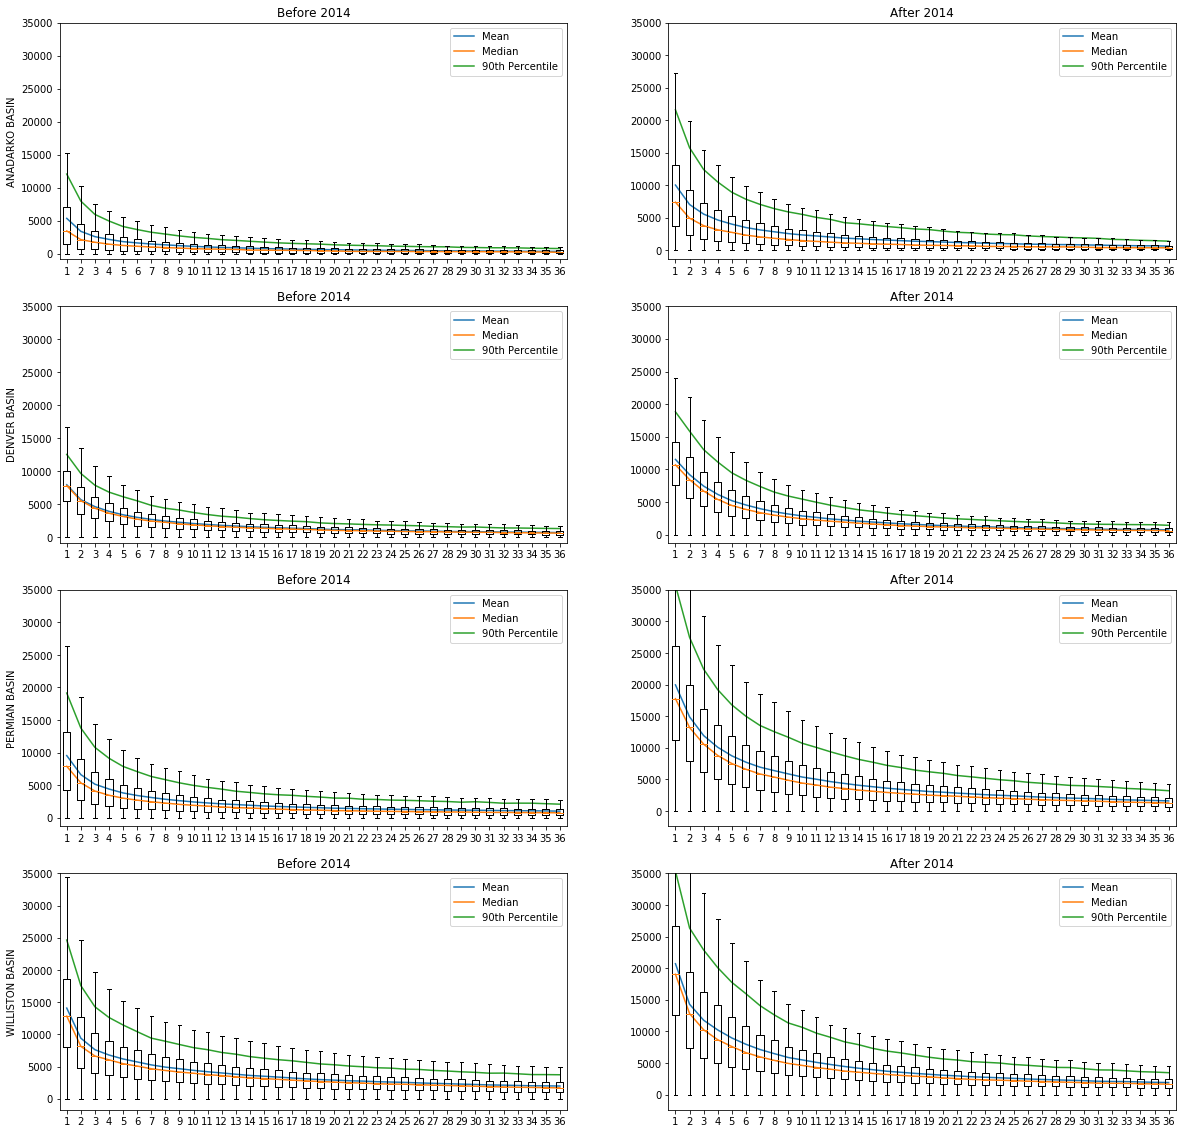

In [111]:
plt.rcParams["figure.figsize"]=20,20

idx = 1
for i in range(len(basins)):

    ax1 = plt.subplot(4,2,idx)
    ax1.plot(indices, np.hstack(all_stats_pre[i,:,0]), label="Mean")
    ax1.plot(indices, np.hstack(all_stats_pre[i,:,1]), label="Median")
    ax1.plot(indices, np.hstack(all_stats_pre[i,:,2]), label="90th Percentile")
    ax1.boxplot(list(all_stats_pre[i,:,3]), showfliers=False)
    ax1.set_ylim(top=35000)
    ax1.legend()
    ax1.set_title('Before 2014')
    ax1.set_ylabel(basins[i])
    idx += 1

    ax2 = plt.subplot(4,2,idx)
    ax2.plot(indices, np.hstack(all_stats_post[i,:,0]), label="Mean")
    ax2.plot(indices, np.hstack(all_stats_post[i,:,1]), label="Median")
    ax2.plot(indices, np.hstack(all_stats_post[i,:,2]), label="90th Percentile")
    ax2.boxplot(list(all_stats_post[i,:,3]), showfliers=False)
    ax2.set_ylim(top=35000)
    ax2.set_title('After 2014')
    ax2.legend()
    
    idx += 1
    
plt.savefig('part1.png')



In [ ]:
#remove months larger than 60
five_years_data = indexed_wells_4basins
five_years_data['max_index_five_years'] = five_years_data['index'].groupby(five_years_data['API']).transform("max")
five_years_data = five_years_data[five_years_data['max_index_five_years'] >= 60]
five_years_data = five_years_data[five_years_data['index'] <= 60]

In [ ]:
def cumm_prod_basin_year(basin, table):
    total = table[(table['BasinName'] == basin)]
    total_liquid = total["Liquid"].sum()
    percents = np.zeros(5)
    for year in range(5):
        lower = (year)*12
        upper = (year + 1)*12
        group = total[(total['index'] > lower) & (total['index'] <= upper)]['Liquid']
        group_liquid = group.sum()
        percents[year] = ((group_liquid*100)/total_liquid)                
        
    return percents
    

In [ ]:
percentages = [cumm_prod_basin_year(y, five_years_data) for y in basins ]

plt.rcParams["figure.figsize"]=17,17
labels = ['1st Year', '2nd Year', '3rd Year', '4th Year', '5th Year']
for i in range(len(basins)):

    ax1 = plt.subplot(2,2,i+1)
    ax1.pie(percentages[i], autopct='%1.1f%%', shadow=True)
    ax1.set_title(basins[i])

plt.legend(labels, loc=4)
plt.savefig('Plot2.png')
    